In [15]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler   
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

In [16]:
# Getting the block info dataset
dataset = pd.read_csv('./datasets/dataset.csv')

In [17]:
dataset.columns

Index(['Unnamed: 0', 'block_base_fee', 'difficulty', 'gas_limit', 'gas_used',
       'number', 'size', 'time', 'total_difficulty', '0.25 Tip (Gwei)',
       '0.75 Tip (Gwei)', 'AVG Tip (Gwei)', 'Block Base Fees (ETH)',
       'Block Tips (ETH)', 'Legacy TX count', 'Max Tip (Gwei)',
       'Median Tip (Gwei)', 'Min Tip (Gwei)', 'TX count', 'block_number'],
      dtype='object')

In [18]:
# 2317337 blocks 
len(dataset.index)

2317337

In [19]:
# Data type and column name transformantions 
dataset=dataset[dataset['block_number']<=13165745]
dataset = dataset.drop(columns=['block_number'])
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip", "Legacy TX count":"legacy_tx","TX count":"tx_count"})
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['time'] = dataset['time'].dt.strftime('%Y-%m-%d %H:%M:00')
#dataset['time'] = dataset['time'].dt.floor('Min')
dataset['time'] = pd.to_datetime(dataset['time'])

In [20]:
# eth price dataset from Binance
eth_price = pd.read_csv('./datasets/eth_price.csv')
eth_price

,Unnamed: 0,datetime,eth_price
0,0,2021-08-05 12:33:00,2615.68
1,1,2021-08-05 12:34:00,2608.04
2,2,2021-08-05 12:35:00,2615.22
3,3,2021-08-05 12:36:00,2620.99
4,4,2021-08-05 12:37:00,2618.12
...,...,...,...
525995,525995,2022-08-05 19:08:00,1667.74
525996,525996,2022-08-05 19:09:00,1668.26
525997,525997,2022-08-05 19:10:00,1669.79
525998,525998,2022-08-05 19:11:00,1670.99


In [21]:
# Data type and column name transformantions 
eth_price['datetime'] = pd.to_datetime(eth_price['datetime'])
#eth_price = eth_price[eth_price['datetime'] <= '2022-08-05 12:33:00']
eth_price = eth_price[eth_price['datetime'] <= '2021-09-05 12:33:00']
eth_price = eth_price.rename(columns={'datetime': 'time'})
eth_price = eth_price.drop(columns=['Unnamed: 0'])
eth_price = eth_price.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset.merge(eth_price, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price

In [22]:
dataset = ds_aux
dataset = dataset.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset = dataset.dropna()
dataset = dataset.drop(columns=['total_difficulty'])

dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,legacy_tx,max_tip,median_tip,min_tip,tx_count,eth_price
0,1000000000,7742494561645080,30029122,30025257,12965000,584,2021-08-05 12:33:00,22.000000,32.000000,35.122037,0.030025,0.813216,259.0,1558.000000,25.000000,22.000000,259.0,2615.68
1,1124967822,7742495635386904,29999798,29985144,12965001,579,2021-08-05 12:33:00,25.875032,44.900606,33.106784,0.033732,0.926795,256.0,98.875032,28.380162,21.375032,257.0,2615.68
2,1265451421,7738716193681762,29970503,29950343,12965002,577,2021-08-05 12:34:00,20.734549,25.484549,24.922555,0.037901,0.712779,321.0,77.734549,20.734549,20.734549,321.0,2608.04
3,1423420054,7742495937440032,29941236,29933895,12965003,586,2021-08-05 12:34:00,25.576580,34.876580,31.892835,0.042609,0.965993,257.0,128.576580,26.576580,0.000000,265.0,2608.04
4,1601260312,7742497011181856,29911998,29895283,12965004,579,2021-08-05 12:34:00,31.273740,45.398740,49.536780,0.047870,1.400710,276.0,498.398740,45.398740,28.098740,280.0,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197780,71396081333,8755889370449241,30000000,5136951,13165741,586,2021-09-05 12:31:00,13.000000,32.603919,23.200289,0.366758,0.133651,83.0,98.014753,18.731808,0.000000,105.0,3941.22
197781,65527889262,8755893665416537,30000000,29997191,13165742,588,2021-09-05 12:32:00,7.472111,23.472111,23.445237,1.965653,0.619297,315.0,2218.692039,12.721745,0.000000,404.0,3939.01
197782,73717341521,8738796605568569,30000000,3081060,13165743,583,2021-09-05 12:32:00,13.282658,30.282658,20.552316,0.227128,0.055887,71.0,38.282658,23.757956,1.082658,71.0,3939.01
197783,66395403434,8743067891065927,30000000,29979655,13165744,583,2021-09-05 12:33:00,2.147625,11.000000,10.185925,1.990511,0.251371,137.0,252.335731,6.189447,0.000000,308.0,3937.05


In [23]:
# Drop not relevant columns
dataset = dataset.drop(columns=['time','number'])

def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    for i in range (1,n+1):
        ds['block_base_fee_'+str(i)] = np.nan
        ds['difficulty_'+str(i)] = np.nan
        ds['gas_limit_'+str(i)] = np.nan
        ds['gas_used_'+str(i)] = np.nan
        ds['size_'+str(i)] = np.nan
        ds['Q1_tip_'+str(i)] = np.nan
        ds['Q3_tip_'+str(i)] = np.nan
        ds['avg_tip_'+str(i)] = np.nan
        ds['block_base_fees_eth_'+str(i)] = np.nan
        ds['block_tips_eth_'+str(i)] = np.nan
        ds['max_tip_'+str(i)] = np.nan
        ds['median_tip_'+str(i)] = np.nan
        ds['eth_price_'+str(i)] = np.nan

    for i in range (1,n+1):        
        ds['block_base_fee_'+str(i)] = ds['block_base_fee'].shift(i)
        ds['difficulty_'+str(i)] = ds['difficulty'].shift(i)
        ds['gas_limit_'+str(i)] = ds['gas_limit'].shift(i)
        ds['gas_used_'+str(i)] = ds['gas_used'].shift(i)
        ds['size_'+str(i)] = ds['size'].shift(i)
        ds['Q1_tip_'+str(i)] = ds['Q1_tip'].shift(i)
        ds['Q3_tip_'+str(i)] = ds['Q3_tip'].shift(i)
        ds['avg_tip_'+str(i)] = ds['avg_tip'].shift(i)
        ds['block_base_fees_eth_'+str(i)] = ds['block_base_fees_eth'].shift(i)
        ds['block_tips_eth_'+str(i)] = ds['block_tips_eth'].shift(i)
        ds['max_tip_'+str(i)] = ds['max_tip'].shift(i)
        ds['median_tip_'+str(i)] = ds['median_tip'].shift(i)
        ds['eth_price_'+str(i)] = ds['eth_price'].shift(i)
    
    return ds

dataset_n1 = reorder_dataset(dataset,1)
dataset_n3 = reorder_dataset(dataset,3)
dataset_n5 = reorder_dataset(dataset,5)
dataset_n10 = reorder_dataset(dataset,10)

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['block_base_fees_eth_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [24]:
dataset_n1 = dataset_n1.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n3 = dataset_n3.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n5 = dataset_n5.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n10 = dataset_n10.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

In [25]:
#### Drop blocks without full history ####
dataset_n1 = dataset_n1.dropna()
dataset_n3 = dataset_n3.dropna()
dataset_n5 = dataset_n5.dropna()
dataset_n10 = dataset_n10.dropna()

In [26]:
alphas = [0.1,0.3, 0.5, 0.8, 1]
random_grid = {'lasso__alpha': alphas,
}
print(random_grid)

best_metric = 0
best_N = 0

steps = [('scaler', StandardScaler()), ('lasso', Lasso())]
pipeline = Pipeline(steps)

#N = [1,3,5,10,50]
N = [1,3,5,10]

for n in N:
    
    if n == 1:
        lasso_df = dataset_n1
    elif n ==3:
        lasso_df = dataset_n3
    elif n ==5:
        lasso_df = dataset_n5
    elif n ==10:
        lasso_df = dataset_n10



    X = lasso_df.drop('min_tip', axis=1)
    y = lasso_df['min_tip']
    tscv = TimeSeriesSplit(n_splits=3, test_size=math.floor(len(dataset_n1)*0.2), gap=n)
    lasso_bayes = BayesSearchCV(pipeline, random_grid, n_iter = 11, cv = tscv, verbose=0, random_state=42, n_jobs = -1)
    lasso_bayes.fit(X, y)
    print(n)
    print(lasso_bayes.best_estimator_)
    print(lasso_bayes.best_score_)
    if best_metric < lasso_bayes.best_score_:
        lasso = lasso_bayes.best_estimator_[1]
        best_metric = lasso_bayes.best_score_
        best_N = n
        
print("Best N and model: ", best_N, lasso)
print("Best metric: ", best_metric)
    

{'lasso__alpha': [0.1, 0.3, 0.5, 0.8, 1]}
1
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso())])
0.4810311532025629
3
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.5))])
0.5134572027855571
5
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.8))])
0.5192464596756283
10
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.8))])
0.5232281360511672
Best N and model:  10 Lasso(alpha=0.8)
Best metric:  0.5232281360511672


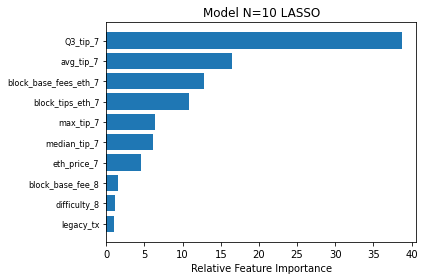

In [27]:
feature_importance = abs(lasso.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N='+str(best_N)+' LASSO')

plt.tight_layout()   
plt.show()

In [28]:
#### Real data validation ####
# Getting the block info dataset
#dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')
dataset_validation = pd.read_csv('./datasets/dataset.csv')

# Data type and column name transformantions 
dataset_validation=dataset_validation[dataset_validation['block_number']>=13265745]
dataset_validation=dataset_validation[dataset_validation['block_number']<=13365745]
dataset_validation = dataset_validation.drop(columns=['block_number'])
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation = dataset_validation.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip", "Legacy TX count":"legacy_tx","TX count":"tx_count"})
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])
dataset_validation['time'] = dataset_validation['time'].dt.strftime('%Y-%m-%d %H:%M:00')
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])

In [29]:
# eth price dataset from Binance
eth_price_validation = pd.read_csv('./datasets/eth_price.csv')

# Data type and column name transformantions 
eth_price_validation['datetime'] = pd.to_datetime(eth_price_validation['datetime'])
#eth_price_validation = eth_price_validation[eth_price_validation['datetime'] <= '2022-08-22 08:22:00']
eth_price_validation = eth_price_validation[eth_price_validation['datetime'] <= '2021-10-06 01:44:00']
eth_price_validation = eth_price_validation.rename(columns={'datetime': 'time'})
eth_price_validation = eth_price_validation.drop(columns=['Unnamed: 0'])
eth_price_validation = eth_price_validation.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset_validation.merge(eth_price_validation, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


eth_price_validation

,time,eth_price
0,2021-08-05 12:33:00,2615.68
1,2021-08-05 12:34:00,2608.04
2,2021-08-05 12:35:00,2615.22
3,2021-08-05 12:36:00,2620.99
4,2021-08-05 12:37:00,2618.12
...,...,...
88627,2021-10-06 01:40:00,3477.19
88628,2021-10-06 01:41:00,3481.89
88629,2021-10-06 01:42:00,3485.79
88630,2021-10-06 01:43:00,3487.99


In [30]:
dataset_validation = ds_aux
dataset_validation = dataset_validation.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset_validation = dataset_validation.dropna()
dataset_validation = dataset_validation.drop(columns=['total_difficulty'])

In [31]:
# Drop not relevant columns
dataset_validation = dataset_validation.drop(columns=['time','number'])

dataset_validation = reorder_dataset(dataset_validation,best_N)

dataset_validation = dataset_validation.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

#### Drop blocks without full history ####
dataset_validation = dataset_validation.dropna()

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['block_base_fees_eth_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_7570/1100609202.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [32]:
##### N=10 with scaled LASSO#####
y_validation = dataset_validation['min_tip']
X_validation = dataset_validation.drop('min_tip', axis=1)


scaler_validation = StandardScaler()
X_validation = scaler_validation.fit_transform(X_validation)

y_val_pred_lasso = lasso.predict(X_validation)
y_val_pred_lasso = np.maximum(y_val_pred_lasso, 0.)

print('Accuracy for model with info for 10 blocks scaled LASSO: ', lasso.score(X_validation, y_validation))
print('mean_squared_error for model with info for 10 blocks scaled LASSO: ', mean_squared_error(y_validation, y_val_pred_lasso))
print('mean_absolute_error for model with info for 10 blocks scaled LASSO: ', mean_absolute_error(y_validation, y_val_pred_lasso))

Accuracy for model with info for 10 blocks scaled LASSO:  0.20011549054066669
mean_squared_error for model with info for 10 blocks scaled LASSO:  983.2678771918739
mean_absolute_error for model with info for 10 blocks scaled LASSO:  1.654861718037493


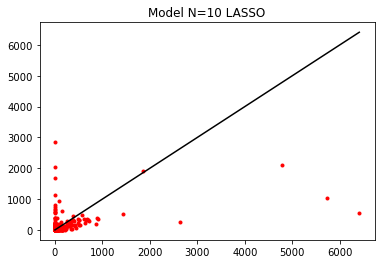

In [33]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N='+str(best_N)+' LASSO')


plt.show()

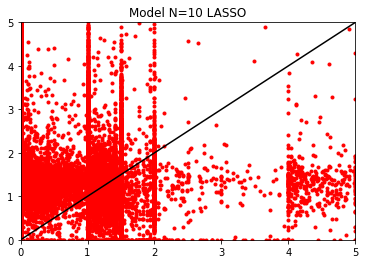

In [34]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N='+str(best_N)+' LASSO')
plt.xlim(0,5)
plt.ylim(0,5)

plt.show()

In [35]:
y_val_array = np.array(y_validation)
lower_values=0
for i in range(0,len(y_val_array)):
    if y_val_pred_lasso[i] <= y_val_array[i]:
        lower_values=lower_values+1

print("Amount of predicted min tip that wouldn't be enough to go through:" , lower_values)
print("Percetage of predicted min tip that wouldn't be enough to go through: ", (lower_values/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through: 14667
Percetage of predicted min tip that wouldn't be enough to go through:  14.94817517504255 %
